# Score de recuperação de Crédito Cartão de crédito banco 'ANS'

# 1. Descrição do problema a ser resolvido<a id='section1'></a>

Esta base de dados é composta por clientes devedores de cartões de crédito emitidos por um banco nacional.
Um dado importante a se observar é que esses clientes não são correntistas desse banco, apenas são usuários dos cartões emitidos pela instituição.

Estes clientes são enviados a empresas recuperadoras de crédito e permanecem pelo período médio de 45 dias na base dessas.
Se a dívida é recuperada durante esse período a empresa recuperadora é comissionada. Caso contrário o cliente é removido da base da recuperadora e enviado a outra empresa para outra tentativa.

Cada instância do dataset é composta por um cliente que foi enviado a empresa recuperadora de crédito e foi classificada como "Cliente Pagou a dívida ou Cliente não pagou a dívida".

O objetivo é descobrirmos, dado as características do cliente e da dívida, quais possuem maior probabilidade de recuperação e assim direcionar o investimento da empresa recuperadora.



### 1.1 Descrição do Dataset

**loja:** Tipo detalhado do cartão de crédito, ex: [*Black Uniclass/ NCC,CARTÃO PÃO DE ACUCAR 2.0,BRASTEMP ITAUCARD*].  
**cpf_cnpj:** número do cpf  
**scorecontratante:** Behavior score calculado pelo banco que demonstra o histórico de pagamentos antes da dívida.  
**dataentrada:** Data em que a empresa recuperadora de crédito recebeu o cliente devedor.  
**validadecampanha:** Data em que o cpf foi retirado da base da empresa de recuperação.  
**atrasocongelado:** Número de dias em atraso da fatura do cartão na data em que o cliente foi enviado.  
**valorcartacampanha:** Montante da dívida acumulada.  
**vlclusters:** Valor de risco do contrato (valores vencidos + parcelamentos).  
**status_boletagem:** Indica se o banco realizou ação de envio de carta com proposta para o cliente.  
**data_status_boletagem:** Data que a empresa poderá realizar ação de carta.  
**desconto:** Desconto disponível para  empresa recuperadora oferecer para quitação da dívida.  
**bandeira:** Tipo agrupado do cartão de crédito.  
**publico:** Informação do histórico de atendimento do cliente na central do banco.  
**matriz:** Classificação da atualização do cadastro do cliente. *1 : Muito antigo, 2: Antigo, 3: Recente, 4: Muito recente*.  
**status_pgtos:** Nosso target, 1 indica que o cliente quitou a dívida, 0 indica que não houve pagamento.  
**acionamentos:** Número de ligações realizado pela empresa.  
**valor_pago:** Valor do pagamento efetuado pelo cliente.  

**Atributos numéricos**: scorecontratante, dataentrada, validadecampanha, atrasocongelado, valorcartacampanha, vlclusters, data_status_boletagem, desconto, acionamentos, valor_pago

**Atributos categóricos**: loja, cpf, status_boletagem, bandeira, publico, matriz 

## Preparação dos dados

#### Importando módulos necessários

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import numpy as np 
from IPython.display import HTML
import umap
from matplotlib import pyplot 
import time 
from sklearn.manifold import TSNE
import pandas as pd 
from sklearn.decomposition import PCA
from sklearn.utils import resample 
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV 
import pickle 
import joblib 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import math
import pandas_profiling

#### Importando os dados para um df pandas

Vamos importar o dataframe utilizando a funcao read csv padrão do pandas, analisando as colunas, tipos e valores nulos.

In [2]:
df = pd.read_csv(r"data\prever_novo2.csv", encoding="latin1", delimiter=";", decimal = ",")
df.head()

,LOJA,cpf_cnpj,scorecontratante,dataentrada,validadecampanha,atrasocongelado,valorcartacampanha,vlclusters,status_boletagem,data_status_boletagem,desconto,bandeira,publico,matriz,status_pgtos,Acionamentos,Valor_Pago
0,CARTÃO PRIV LBL FIC ASSAI,99999999999,425,21/02/2019 00:00:00,17/04/2019,253,1582.10,1894.25,BOLETAR_A_PARTIR_,17/03/2019,50.72,FC,0,3,0,26,NaN
1,CARTÃO EXTRA 2.0,99999999999,428,25/04/2019 00:00:00,19/06/2019,192,392.90,439.42,BOLETAR_A_PARTIR_,19/05/2019,33.60,FC,0,4,0,0,NaN
2,MAGAZINE LUIZA/LUIZACRED FLEX,99999999999,343,02/03/2019 00:00:00,26/04/2019,197,1069.87,1353.72,BOLETAR_A_PARTIR_,26/03/2019,42.52,LC,0,3,0,5,NaN
3,CARTÃO EXTRA 2.0,99999999999,353,13/12/2018 00:00:00,06/02/2019,369,1002.21,1717.83,BOLETAR_A_PARTIR_,06/01/2019,71.04,FC,0,3,0,7,NaN
4,CARTÃO EXTRA 2.0,99999999999,371,18/04/2019 00:00:00,12/06/2019,307,874.41,988.66,BOLETAR_A_PARTIR_,12/05/2019,53.04,FC,ElegÃ­vel ExceÃ§Ã£o,3,0,1,NaN


In [3]:
summary=df.iloc[:,2:].describe()
summary=summary.transpose()
summary.head()

,count,mean,std,min,25%,50%,75%,max
scorecontratante,111848.0,382.911791,52.770761,0.00,355.000,384.000,410.00,669.00
atrasocongelado,111848.0,277.934679,70.594797,29.00,215.000,270.000,326.00,3158.00
valorcartacampanha,111848.0,2052.372657,2966.802855,10.91,705.720,1208.810,2093.37,68142.76
vlclusters,111848.0,3197.461223,5197.741832,0.00,928.085,1622.445,3082.33,97304.57
desconto,111848.0,56.063354,14.671651,0.00,44.900,54.200,68.19,99.00


In [4]:
df.profile_report(style={'full_width':True})

### Analisando o profiling

* **Acionamentos has 52469 (46.9%) zeros** -> Nesse caso não é um problema, pois o acionamento zero significa cliente não acionado
* **cpf_cnpj has constant value "99999999999"** -> Foi colocado de propósito para mascarar o número de cpf verdadeiro
* **data_status_boletagem has a high cardinality: 256 distinct values** -> Ok, é uma data, ajustaremos tipo
* **dataentrada only contains datetime values, but is categorical. Consider applying pd.to_datetime()** ->  Ok, é uma data, ajustaremos tipo
* **dataentrada has a high cardinality: 118 distinct values** -> Ok, é uma data, ajustaremos tipo
* **LOJA has a high cardinality: 102 distinct values** -> (2) Iremos criar uma função para agrupar as principais
* **validadecampanha has a high cardinality: 115 distinct values** ->  Ok, é uma data, ajustaremos tipo
* **Valor_Pago is highly skewed (γ1 = 33.77991844)** -> Ok, não será usado como feature, é consequencia da target
* **Valor_Pago has 109295 (97.7%) zeros** -> Ok, significa que o cliente não pagou
* **vlclusters is highly correlated with valorcartacampanha (ρ = 0.9411102672)** -> Tratar para escolher um dos dois.

Com isso, o pré-processamento consistirá em : (1) Ajustar tipos de data, (2) Agrupar variável categórica de alta cardinalidade (ex: loja), (3) Usar algum recurso de redução de dimensionalidade para eliminar uma das variáveis altamente correlacionadas.

Outro ponto importante que podemos já analisar através do profiling é que não foi possível identificar a primeira vista correlação da variável target com outras features

#### Pré-processamento 1 - Ajustando tipos de variáveis

In [5]:
df.dtypes

LOJA                      object
cpf_cnpj                   int64
scorecontratante           int64
dataentrada               object
validadecampanha          object
atrasocongelado            int64
valorcartacampanha       float64
vlclusters               float64
status_boletagem          object
data_status_boletagem     object
desconto                 float64
bandeira                  object
publico                   object
matriz                     int64
status_pgtos               int64
Acionamentos               int64
Valor_Pago               float64
dtype: object

Além do problema das datas, o campo matriz apesar de ser respresntado com números é um campo categórico

In [6]:
df['matriz'] = df['matriz'].astype('object')

Ajustando datas

In [7]:
df['dataentrada'] = pd.to_datetime(df['dataentrada'])
df['validadecampanha'] = pd.to_datetime(df['validadecampanha'])

In [8]:
df['data_status_boletagem'].value_counts() # Tentando converter esse campo percebemos valores zerados, vamos analisar o impacto de dropar essas linhas

20/01/2019    3447
0             3427
17/03/2019    3378
18/03/2019    3136
12/05/2019    2294
              ... 
04/05/2018       1
20/04/2018       1
01/02/2019       1
15/06/2018       1
08/02/2019       1
Name: data_status_boletagem, Length: 256, dtype: int64

In [9]:
df['status_pgtos'].value_counts() # Como estamos tratando uma classe rara, temos que tomar cuidado com a deleção de ocorrencias positivas

0    109295
1      2553
Name: status_pgtos, dtype: int64

In [10]:
df[df['data_status_boletagem']=='0']['status_pgtos'].value_counts() # Tratando-se de 4% apenas da classe positiva vamos remover 

0    3328
1      99
Name: status_pgtos, dtype: int64

In [11]:
df = df[df['data_status_boletagem']!='0']
df = df[df['data_status_boletagem']!='.']

In [12]:
df['data_status_boletagem'] = pd.to_datetime(df['data_status_boletagem'])

#### Pré-processamento 2 - Tratando colunas categóricas

Nessa etapa vamos agrupar e tratar as colunas categóricas

In [13]:
colunas_categoricas = pd.DataFrame({'column': df.dtypes[df.dtypes == 'object'].index,
                                   'type': list(df.dtypes[df.dtypes == 'object']),
                                   'categories': df[df.dtypes[df.dtypes == 'object'].index].nunique()}) \
                                 .reset_index(drop=True) \
                                 .sort_values(by=['categories'], ascending=False)
colunas_categoricas

,column,type,categories
0,LOJA,object,98
2,bandeira,object,7
3,publico,object,7
4,matriz,object,4
1,status_boletagem,object,2


d:\python\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\python\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 129 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\python\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0, flags=flags)
d:\python\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 129 missing from current font.
  font.set_text(s, 0, flags=flags)


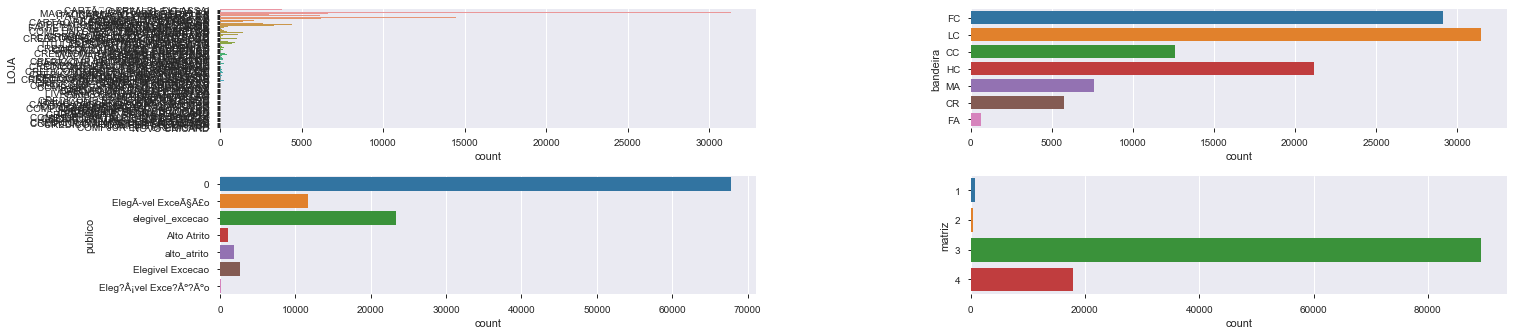

<Figure size 640x480 with 0 Axes>

In [14]:
def exibe_categoricas():
    colunas_categoricas = pd.DataFrame({'column': df.dtypes[df.dtypes == 'object'].index,
                                   'type': list(df.dtypes[df.dtypes == 'object']),
                                   'categories': df[df.dtypes[df.dtypes == 'object'].index].nunique()}) \
                                 .reset_index(drop=True) \
                                 .sort_values(by=['categories'], ascending=False)
    colunas_categoricas = list(colunas_categoricas['column'][:4])
    size = math.ceil(len(colunas_categoricas)**(1/2))
    fig, axs = plt.subplots(2, 2)
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    ax_list = []
    for i in range(0,size):
        for j in range(0,size):        
            if(len(ax_list) == len(colunas_categoricas)):
                break
            ax_list.append([i,j])
            sns.countplot(y = df[colunas_categoricas[len(ax_list)-1]], data = df, ax=axs[i, j])

    fig.subplots_adjust(left=0.001, right=2.98, bottom=0.01, top=1, hspace=0.4, wspace=0.4)
    plt.show()

exibe_categoricas()

Como podemos ver a coluna Loja possui alta cardinalidade e foi possível ver através do gráfico a necessidade de tratar a variável público

Analisando os dados, descobrimos que bandeira é um agrupamento de lojas.

In [15]:
df.groupby(['LOJA','bandeira']).size().unstack(fill_value=0).head()

bandeira,CC,CR,FA,FC,HC,LC,MA
LOJA,,,,,,,
AYRTON SENNA ITAUCARD,119,0,0,0,0,0,0
BRASTEMP ITAUCARD,130,0,0,0,0,0,0
Black Uniclass/ NCC,2,0,0,0,0,0,0
CARTAO COBRAND FIC EXTRA,0,0,0,13,0,0,0
CARTAO COBRAND FIC PAO ACUCAR,0,0,0,1,0,0,0


Por observação visual e conhecimento de domínio, resolvemos criar uma nova feature que combina loja e bandeira. Usaremos a bandeira em todos os casos com exceção do grupo CC, que vamos expandir.

#### Tratando Loja

In [16]:
def combina_bandeira_loja(x):
    lista_cc = ['ITAUCARD 2.0 CANAIS DIRETOS','OPERACOES CREDITO CREDICARD',
                'TAM ITAUCARD 2.0','Cartao Cobranded Netshoes 2.0',
                'PL PURO ITAUCARD LOJISTA','TITULARES CARTOES DE CREDITO',
                'CARTÃO IPIRANGA 2.0']
    if x[0][0]=="F":
        return "FC"
    elif x[0] != "CC":
        return x[0]
    elif x[1] in lista_cc:
        return "CC_"+x[1]
    else:
        return "CC_OUTROS"
    
df['bandeira_loja'] = df[['bandeira','LOJA']].apply(combina_bandeira_loja, axis=1)

In [17]:
df['bandeira_loja'].value_counts()

LC                                  31493
FC                                  29796
HC                                  21201
MA                                   7614
CR                                   5729
CC_ITAUCARD 2.0 CANAIS DIRETOS       2988
CC_OUTROS                            2868
CC_OPERACOES CREDITO CREDICARD       2644
CC_TAM ITAUCARD 2.0                  1402
CC_Cartao Cobranded Netshoes 2.0     1065
CC_PL PURO ITAUCARD LOJISTA           897
CC_TITULARES CARTOES DE CREDITO       723
Name: bandeira_loja, dtype: int64

In [18]:
df  = df.drop(columns=['LOJA','bandeira'])

#### Tratando público

In [19]:
def converte_publico(x):
    if x=="Eleg?¡vel Exce?º?úo" or x=="Elegível Exceção" or x=="Elegivel Excecao" or x=="ElegÃ­vel ExceÃ§Ã£o" or x=="Eleg?Â¡vel Exce?Âº?Ãºo" or x=="Eleg?el Exce?o" or x=="Eleg??vel Exce????":
        return "elegivel_excecao"
    elif x=="Alto Atrito":
        return "alto_atrito"
    elif x=="0" or x=="883000140672" or x=="8,83E+11":
        return "nao_definido"
    else:
        return x

df['publico'] = df['publico'].apply(converte_publico)
df['publico'].value_counts()

nao_definido        67747
elegivel_excecao    37719
alto_atrito          2954
Name: publico, dtype: int64

Nesse caso o não definido não se trata de um nulo, mas sim que o cliente não entrou com reclamação nos canais do banco

Um tratamento extra, porém não essencial: Valor pago zerado significa que aquele cliente não pagou, vamos preencher com zeros

In [20]:
df['Valor_Pago'] = df['Valor_Pago'].fillna(0)

In [21]:
df.head()

,cpf_cnpj,scorecontratante,dataentrada,validadecampanha,atrasocongelado,valorcartacampanha,vlclusters,status_boletagem,data_status_boletagem,desconto,publico,matriz,status_pgtos,Acionamentos,Valor_Pago,bandeira_loja
0,99999999999,425,2019-02-21,2019-04-17,253,1582.10,1894.25,BOLETAR_A_PARTIR_,2019-03-17,50.72,nao_definido,3,0,26,0.0,FC
1,99999999999,428,2019-04-25,2019-06-19,192,392.90,439.42,BOLETAR_A_PARTIR_,2019-05-19,33.60,nao_definido,4,0,0,0.0,FC
2,99999999999,343,2019-02-03,2019-04-26,197,1069.87,1353.72,BOLETAR_A_PARTIR_,2019-03-26,42.52,nao_definido,3,0,5,0.0,LC
3,99999999999,353,2018-12-13,2019-06-02,369,1002.21,1717.83,BOLETAR_A_PARTIR_,2019-06-01,71.04,nao_definido,3,0,7,0.0,FC
4,99999999999,371,2019-04-18,2019-12-06,307,874.41,988.66,BOLETAR_A_PARTIR_,2019-12-05,53.04,elegivel_excecao,3,0,1,0.0,FC


Gráfico pós tratamento

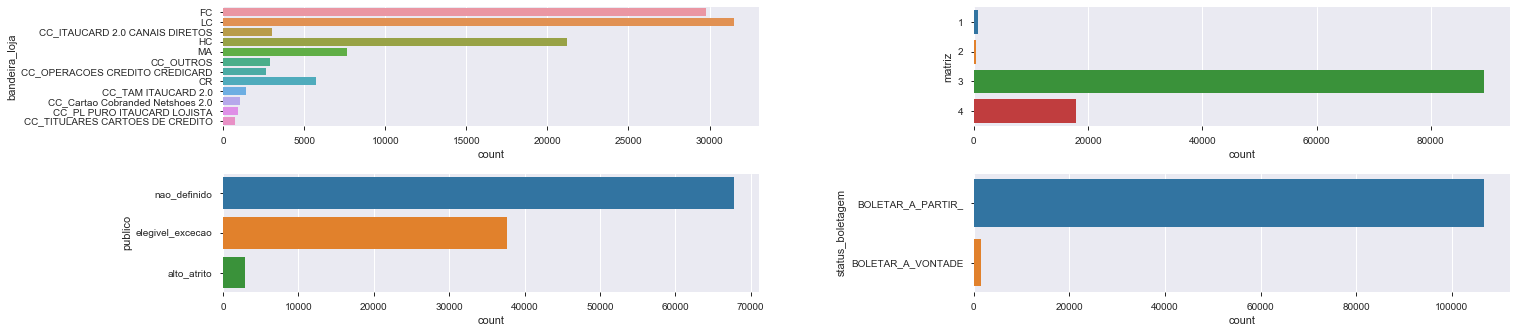

<Figure size 640x480 with 0 Axes>

In [22]:
exibe_categoricas()

#### Transformando colunas categóricas em binárias

Para realizar o one-hot encoding, retiramos algumas variáveis por conhecimento de domínio:
Todas as datas foram retiradas, pois representam apenas a data em que o cliente foi enviado a recuperadora de crédito e data que ele saiu da carteira e em que data houve o envio de ação de mala-direta por parte do banco (informção que já está na variável status_boletagem). Além dessas retiramos CPF, e as coluna Valor pago que é resutante da target.

In [23]:
df.columns

Index(['cpf_cnpj', 'scorecontratante', 'dataentrada', 'validadecampanha',
       'atrasocongelado', 'valorcartacampanha', 'vlclusters',
       'status_boletagem', 'data_status_boletagem', 'desconto', 'publico',
       'matriz', 'status_pgtos', 'Acionamentos', 'Valor_Pago',
       'bandeira_loja'],
      dtype='object')

In [24]:
colunas_treino = ['bandeira_loja',
                  'scorecontratante',
                  'atrasocongelado',
                  'valorcartacampanha',
                  'vlclusters',
                  'status_boletagem',
                  'desconto',
                  'publico',
                  'matriz',
                  'Acionamentos',
                  'status_pgtos'
                 ]

In [25]:
df = pd.get_dummies(df[colunas_treino])

In [26]:
df.columns

Index(['scorecontratante', 'atrasocongelado', 'valorcartacampanha',
       'vlclusters', 'desconto', 'Acionamentos', 'status_pgtos',
       'bandeira_loja_CC_Cartao Cobranded Netshoes 2.0',
       'bandeira_loja_CC_ITAUCARD 2.0 CANAIS DIRETOS',
       'bandeira_loja_CC_OPERACOES CREDITO CREDICARD',
       'bandeira_loja_CC_OUTROS', 'bandeira_loja_CC_PL PURO ITAUCARD LOJISTA',
       'bandeira_loja_CC_TAM ITAUCARD 2.0',
       'bandeira_loja_CC_TITULARES CARTOES DE CREDITO', 'bandeira_loja_CR',
       'bandeira_loja_FC', 'bandeira_loja_HC', 'bandeira_loja_LC',
       'bandeira_loja_MA', 'status_boletagem_BOLETAR_A_PARTIR_',
       'status_boletagem_BOLETAR_A_VONTADE', 'publico_alto_atrito',
       'publico_elegivel_excecao', 'publico_nao_definido', 'matriz_1',
       'matriz_2', 'matriz_3', 'matriz_4'],
      dtype='object')

#### Separando treino e teste

Por se tratar de uma classe rara o conjunto de treino será balanceado

In [27]:
df['status_pgtos'].value_counts()

0    105966
1      2454
Name: status_pgtos, dtype: int64

In [28]:
X = df.drop(['status_pgtos'], axis=1)
y = df[['status_pgtos']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (86736, 27)
X_test: (21684, 27)
y_train: (86736, 1)
y_test: (21684, 1)


In [29]:
X_train_maioria = X_train[y_train.status_pgtos==0]
X_train_minoria = X_train[y_train.status_pgtos==1]
X_train_maioria_randomizado = resample(X_train_maioria, 
                                       replace=True,     
                                       n_samples=1982,    
                                       random_state=42)
X_train_balanceado = pd.concat([X_train_maioria_randomizado, X_train_minoria])
y_train_balanceado = y_train.loc[X_train_balanceado.index]
y_train_balanceado.status_pgtos.value_counts()

1    1982
0    1982
Name: status_pgtos, dtype: int64

In [30]:
y_train_balanceado = y_train_balanceado.values.ravel()

#### Primeiro treinamento

Para facilitar os diversos testes vamos criar uma função que irá rodar um gridsearch com: cross validation folds de 5, usando como score área sobre a curva roc, estimador regressão logistica e dos variando 3 hiperparâmetros básicos, nos retornando o grid result.

In [31]:
def roda_grid_search(x,y,regularizacao=False):
    if regularizacao:
        param_grid_lr = {
        'dual': [True,False],
        'max_iter': [60,80,100,110,120,130,140],
        'C': [1.0,1.5,2.0,2.5,3.5, 4.0, 4.5,5.0,5.5,6.0,6.5,7.0]
        }
    else:
        param_grid_lr = {
        'dual': [True,False],
        'max_iter': [30,60,80,100,110,120,130,140]        
        }
    lr = LogisticRegression(solver='liblinear')
    grid_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_result = grid_lr.fit(x, y)
    return grid_result    

Sem reaizar nenhum tratamento extra, regularização, nem normalização, vamos rodar uma regressão logística para pegar o primeiro score como base.

In [32]:
resultado1 = roda_grid_search(X_train_balanceado,y_train_balanceado)
print(resultado1.best_score_)

0.642517942504344


Teremos como base o score de curva roc de **0.642** para as próximas melhorias

#### Melhoria 1: Usando PCA

**Comentar melhor essa parte!**

In [33]:
df_train_pca = X_train_balanceado
df_train_pca.head()

,scorecontratante,atrasocongelado,valorcartacampanha,vlclusters,desconto,Acionamentos,bandeira_loja_CC_Cartao Cobranded Netshoes 2.0,bandeira_loja_CC_ITAUCARD 2.0 CANAIS DIRETOS,bandeira_loja_CC_OPERACOES CREDITO CREDICARD,bandeira_loja_CC_OUTROS,...,bandeira_loja_MA,status_boletagem_BOLETAR_A_PARTIR_,status_boletagem_BOLETAR_A_VONTADE,publico_alto_atrito,publico_elegivel_excecao,publico_nao_definido,matriz_1,matriz_2,matriz_3,matriz_4
110933,400,359,5769.56,11712.44,75.23,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
109488,362,368,332.19,952.20,81.85,0,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
38919,388,195,1108.22,1305.03,40.42,2,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
69739,411,195,564.00,759.44,48.37,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
30937,357,195,1536.16,1781.43,40.73,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1


In [34]:
pca = PCA()
pca.fit(df_train_pca)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [35]:
pcs = ['pc'+str(x) for x in range (1,28)]

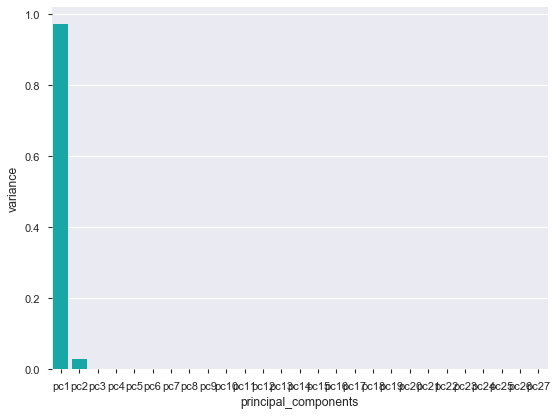

In [36]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
data = {'variance':pca.explained_variance_ratio_, 'principal_components':pcs}
df_variance = pd.DataFrame(data)
sns.barplot(x='principal_components',y='variance', data=df_variance, color='c');

O gráfico acima demonstra que há uma forte concentração em pc1


In [37]:
df_train_transformed = pca.fit_transform(df_train_pca)
df_train_transformed = pd.DataFrame(df_train_transformed, columns=pcs)
df_train_transformed.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27
0,9651.384438,-1419.205709,37.629247,-27.199020,2.963143,-2.179812,0.673432,-0.200455,-0.083645,-0.966364,...,0.013047,0.013559,-0.011037,-0.022137,-0.006310,-0.011167,1.444485e-11,-5.565634e-12,1.098729e-11,-1.049414e-13
1,-2356.058716,-338.497380,85.607700,-15.674511,-13.361585,-4.035870,-0.568287,0.230037,-0.167104,-0.019295,...,-0.016575,-0.005281,-0.014769,-0.006955,-0.011952,0.000238,-2.820441e-12,9.787747e-14,2.536006e-12,9.522639e-13
2,-1645.798190,139.273036,-65.336176,41.594460,1.713957,-0.759355,1.205022,-0.148843,-0.392341,0.264348,...,-0.012813,-0.001682,-0.001985,0.010006,-0.000262,0.020359,-2.499167e-12,2.519638e-13,1.034566e-12,3.125358e-13
3,-2396.704129,-33.346664,-82.283571,20.781119,-5.830312,-3.083143,-0.454865,-0.019455,-0.255011,-0.001764,...,-0.072222,-0.022624,-0.016981,-0.007992,-0.003520,0.026079,-1.267307e-12,1.370964e-12,-9.966597e-13,-6.661867e-13
4,-1015.149030,249.726159,-46.077492,69.194099,1.469364,-2.626844,0.274055,0.899681,0.851702,-0.142927,...,-0.115087,0.012284,-0.010252,-0.055628,-0.008899,0.016461,1.827126e-12,1.677691e-12,1.333948e-12,5.381915e-14


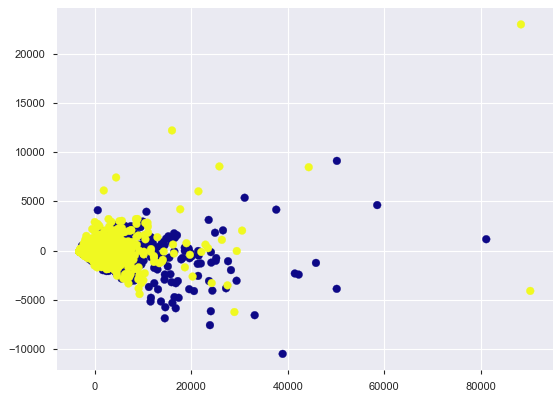

In [38]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(df_train_transformed['pc1'],df_train_transformed['pc2'],c=y_train_balanceado,cmap='plasma')

O gráfico acima nos mostra que é possível ter alguma distinção mesmo que muito fraca

In [39]:
# Gerando gráfico 
df_pcs_result = pd.DataFrame(data, columns = ['pcs', 'roc'])
for i in range(1,28):
    pcs_train = ['pc'+str(x) for x in range(1,i+1)]
    x_train_pc = df_train_transformed[pcs_train].values
    result = roda_grid_search(x_train_pc,y_train_balanceado)
    linha = {'pcs': i, 'roc':result.best_score_}
    df_pcs_result = df_pcs_result.append(linha, ignore_index=True)

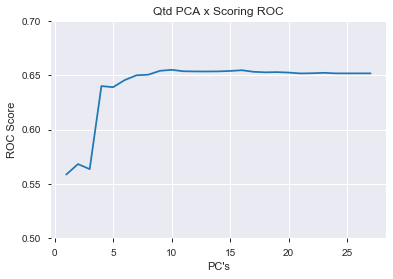

In [40]:
plt.plot(df_pcs_result['pcs'],df_pcs_result['roc'])
plt.yticks(np.arange(0.5, 0.74, 0.05))
plt.title("Qtd PCA x Scoring ROC")
plt.xlabel("PC's")
plt.ylabel("ROC Score");

In [41]:
df_pcs_result[df_pcs_result['pcs']==10]

,pcs,roc
9,10.0,0.654948


Aqui podemos ver que com 10 dimensoes temos um resultado superior do que treinando com as 27 originais.

#### Melhora 2: Normalizando 

A premissa é de que o PCA pode ter tido uma vantagem ao realizar a normalização previamente

In [42]:
escalador_vlrcartacampanha = StandardScaler()
escalador_vlrccluster = StandardScaler()
escalador_vlrdesconto = StandardScaler()
X_train_balanceado['valorcartacampanha'] = escalador_vlrcartacampanha.fit_transform(X_train_balanceado[['valorcartacampanha']].values)
X_train_balanceado['vlclusters'] = escalador_vlrccluster.fit_transform(X_train_balanceado[['vlclusters']].values)
X_train_balanceado['desconto'] = escalador_vlrdesconto.fit_transform(X_train_balanceado[['desconto']].values)

In [43]:
# Regressão logística com normalização
resultado1 = roda_grid_search(X_train_balanceado,y_train_balanceado)
print(resultado1.best_score_)

0.6508247535197897


Ainda o pca ficou um pouquinho melhor

#### Melhora 3: Usando regularização na regressão logística

In [44]:
resultado1 = roda_grid_search(X_train_balanceado,y_train_balanceado,regularizacao=True)
print(resultado1.best_score_)

0.6515680664951051


Ainda o pca ficou um pouquinho melhor, trade-off: menos dimensoes, mais performance, menos overfitting, mas adeus interpretabilidade. 

### Tentando enxergar clusters

#### 1. Kmeans

In [45]:
# Grupos criados através do dataset com as dimensoes reduzidas
from sklearn.cluster import KMeans
clustering = KMeans(n_clusters=3)
x_train_pc = df_train_transformed[['pc1','pc2']].values
clustering.fit(x_train_pc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [46]:
X_clusters = clustering.predict(x_train_pc)

In [47]:
df_clusters =df_train_transformed[['pc1','pc2']]
df_clusters['cluster'] = X_clusters

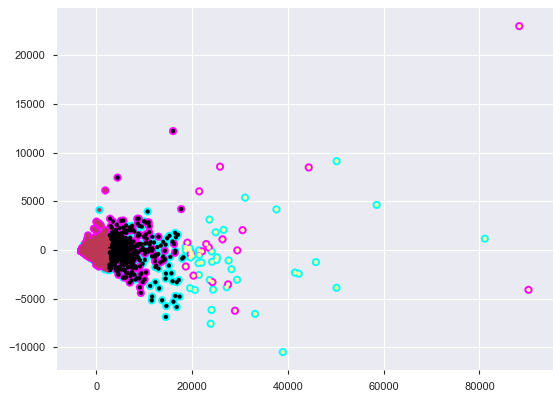

In [48]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(df_clusters['pc1'], df_clusters['pc2'], cmap='cool', c=y_train_balanceado)
plt.scatter(df_clusters['pc1'], df_clusters['pc2'], cmap='inferno', marker='.', c=df_clusters['cluster'])

É possível exergar algumas zonas de concentracao diferentes entre pagantes e não pagantes

#### 2. TSNE

Tentar mexer nos parametros da tsne para ver o que acontece...

In [49]:
tsne = TSNE(perplexity=20)
x_train_tsne = tsne.fit_transform(X_train_balanceado)

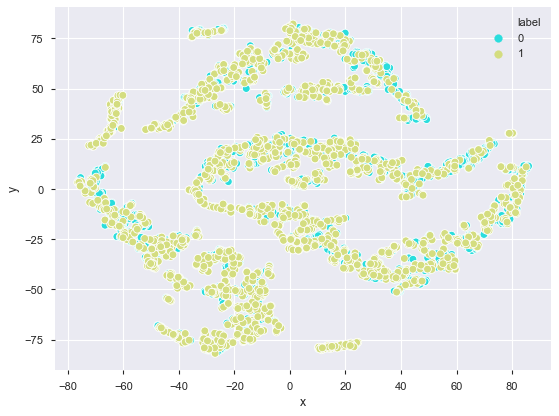

In [50]:
df_tsne = pd.DataFrame(x_train_tsne, columns=['x', 'y'])
df_tsne['label'] =  y_train_balanceado
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
_ = sns.scatterplot(x='x', y='y', data=df_tsne, hue='label', palette='rainbow', legend='full')

#### 3. Umap

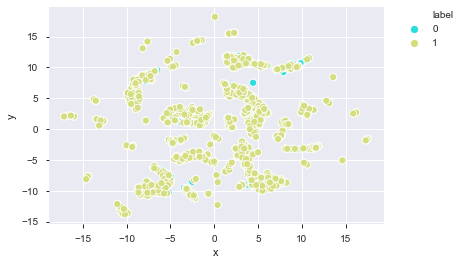

In [52]:
x_umap_transformed = umap.UMAP(n_neighbors=5).fit_transform(X_train_balanceado)
df_umap = pd.DataFrame(x_umap_transformed, columns=['x', 'y'])
df_umap['label'] = y_train_balanceado
_ = sns.scatterplot(x='x', y='y', data=df_umap, hue='label', palette='rainbow', legend='full')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Varirar neighbours e ver o que acaontece...

#### EXTRA: XgBoosting

In [53]:
param_grid_xg = {
        'n_estimators':[100,200,400,600],
        'min_samples_leaf':[5,10,20],
        'subsample': [0.6, 0.8, 1.0]
        }
xg = GradientBoostingClassifier(learning_rate=0.02)
grid_xg = GridSearchCV(estimator=xg, param_grid=param_grid_xg, cv=5, scoring='roc_auc', n_jobs=-1)
pcs_train = ['pc'+str(x) for x in range(1,11)]
x_train_pc = df_train_transformed[pcs_train].values
grid_result_xg = grid_xg.fit(X_train_balanceado,y_train_balanceado)
start_time = time.time()
print("Best: %f using %s" % (grid_result_xg.best_score_, grid_result_xg.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

Best: 0.678617 using {'min_samples_leaf': 20, 'n_estimators': 200, 'subsample': 0.6}
Execution time: 0.0009975433349609375 ms


#### Feature Importance

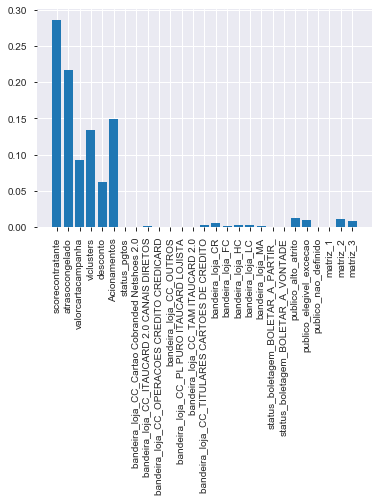

In [54]:
pyplot.bar(range(len(grid_result_xg.best_estimator_.feature_importances_)), grid_result_xg.best_estimator_.feature_importances_)
pyplot.xticks(range(len(grid_result_xg.best_estimator_.feature_importances_)),df.columns, rotation='vertical')
pyplot.show()

### Uma análise final

Mesmo aparentemente um resultado ruim, a nível de negócio o modelo tem **grande** utilidade.
Isso se deve ao fato de que mesmo que a distinção entre clientes que pagaram e clientes que não pagaram não ser perfeita, a separação dos mais propensões ao menos propensões indica para a empresa quais grupos de clientes devem receber mais investimento na tentativa de recuperação de crédito, o que leva a uma diminui;cão considerável do custo.

A tabela abaixo explica melhor.

In [56]:
df_conc = pd.DataFrame()
df_conc['y_previsto'] = grid_result_xg.predict_proba(X)[:,1]
df_conc['y_real'] = df['status_pgtos'].values
df_conc = df_conc.sort_values(by=['y_previsto'],ascending=False)
df_conc = df_conc.reset_index(drop=True)
lista = []
partes = math.ceil(len(df_conc)/20)
for i in range(0,20):
    ini = i*partes
    fim = (i+1)*partes
    qtd = len(df_conc.loc[ini:fim,:].y_real)
    lista.append([i+1,
                  qtd,
                  round(df_conc.loc[ini:fim,:].y_previsto.mean()*100,2),
                  df_conc.loc[ini:fim,:].y_real.sum(),
                  round(df_conc.loc[ini:fim,:].y_real.sum()/qtd*100,2)])
df_exibe = pd.DataFrame(lista,columns=['Grupo','Qtd','Prob prevista média','Pagantes','% de Pagantes'])
df_exibe

,Grupo,Qtd,Prob prevista média,Pagantes,% de Pagantes
0,1,5422,51.82,418,7.71
1,2,5422,44.05,187,3.45
2,3,5422,41.86,206,3.80
3,4,5422,40.19,153,2.82
4,5,5422,38.68,152,2.80
5,6,5422,37.11,139,2.56
6,7,5422,35.41,117,2.16
7,8,5422,33.84,123,2.27
8,9,5422,32.56,128,2.36
9,10,5422,31.21,109,2.01
